Importing necessary libraries

In [248]:
# Basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# To scale numerical data using z-score
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Train-test split
from sklearn.model_selection import train_test_split

# Machine Learning models
from sklearn.linear_model import LogisticRegression

# Metrics to evaluate the model
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve

# Handling class imbalance (if needed)
from imblearn.over_sampling import SMOTE

# To ignore warnings
import warnings
warnings.filterwarnings("ignore")


Reading the data set

In [249]:
# Reading the dataset
import pandas as pd
import requests
from io import StringIO

# Google Drive file link
orig_url = "https://drive.google.com/file/d/1RwszWULCyWTDB0WjvmpW2qposK9mh7yz/view"

# Extract file ID from the URL
file_id = orig_url.split('/')[-2]
dwn_url = 'https://drive.google.com/uc?export=download&id=' + file_id
url = requests.get(dwn_url).text

# Read the CSV file
csv_raw = StringIO(url)
fraud = pd.read_csv(csv_raw, sep=',')  # Adjusted separator for fraud dataset

# Display first few rows
fraud.head()



,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,...,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy
0,Dec,5,Wednesday,Honda,Urban,Tuesday,Jan,1,Female,Single,...,3 years,26 to 30,No,No,External,none,1 year,3 to 4,1994,Liability
1,Jan,3,Wednesday,Honda,Urban,Monday,Jan,4,Male,Single,...,6 years,31 to 35,Yes,No,External,none,no change,1 vehicle,1994,Collision
2,Oct,5,Friday,Honda,Urban,Thursday,Nov,2,Male,Married,...,7 years,41 to 50,No,No,External,none,no change,1 vehicle,1994,Collision
3,Jun,2,Saturday,Toyota,Rural,Friday,Jul,1,Male,Married,...,more than 7,51 to 65,Yes,No,External,more than 5,no change,1 vehicle,1994,Liability
4,Jan,5,Monday,Honda,Urban,Tuesday,Feb,2,Female,Single,...,5 years,31 to 35,No,No,External,none,no change,1 vehicle,1994,Collision


Examining data information

In [250]:
fraud.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15420 entries, 0 to 15419
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Month                 15420 non-null  object
 1   WeekOfMonth           15420 non-null  int64 
 2   DayOfWeek             15420 non-null  object
 3   Make                  15420 non-null  object
 4   AccidentArea          15420 non-null  object
 5   DayOfWeekClaimed      15420 non-null  object
 6   MonthClaimed          15420 non-null  object
 7   WeekOfMonthClaimed    15420 non-null  int64 
 8   Sex                   15420 non-null  object
 9   MaritalStatus         15420 non-null  object
 10  Age                   15420 non-null  int64 
 11  Fault                 15420 non-null  object
 12  PolicyType            15420 non-null  object
 13  VehicleCategory       15420 non-null  object
 14  VehiclePrice          15420 non-null  object
 15  FraudFound_P          15420 non-null

Checking for missing values

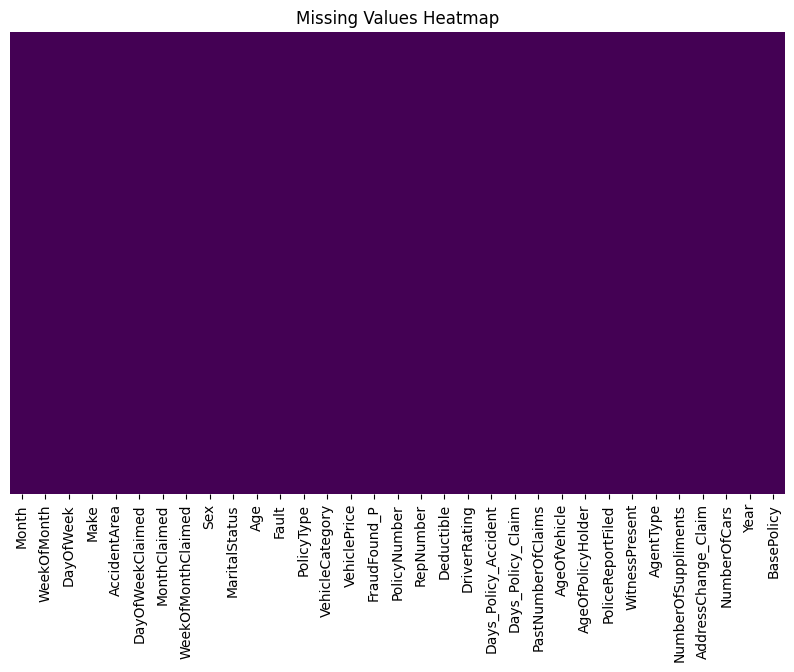

In [251]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.heatmap(fraud.isnull(), cmap='viridis', cbar=False, yticklabels=False)
plt.title("Missing Values Heatmap")
plt.show()




Relationship between Numerical Features


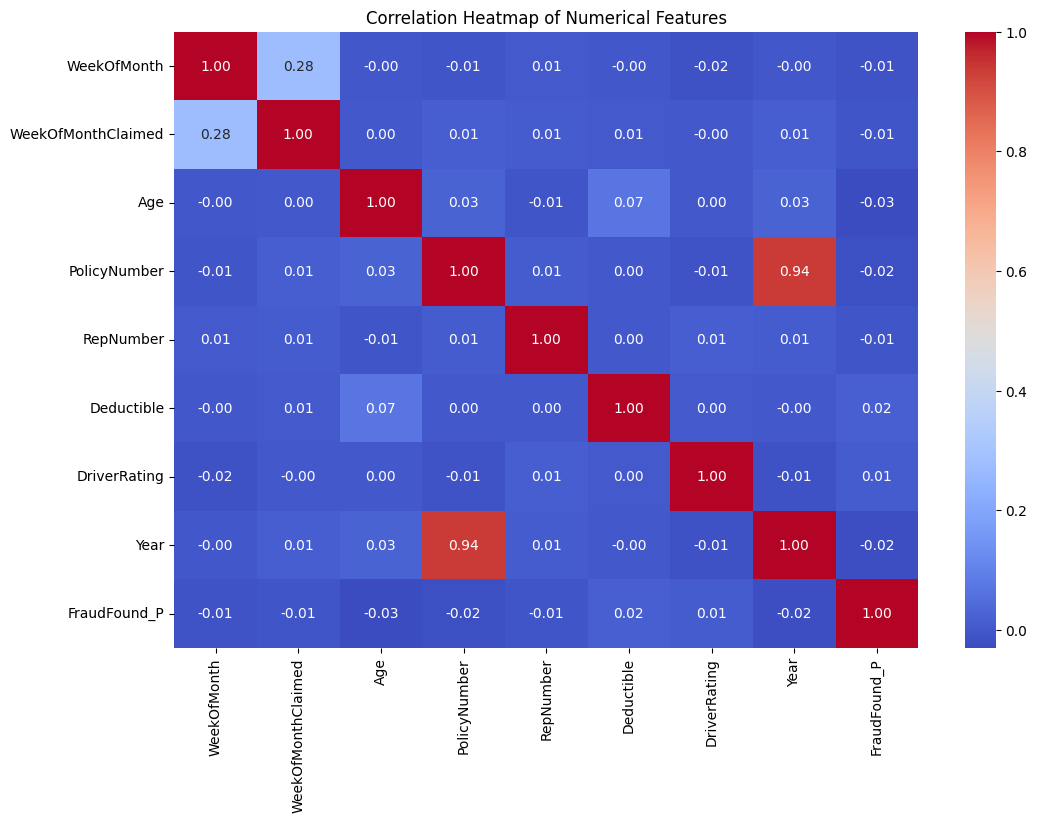

In [252]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select only numerical columns
numerical_features = ["WeekOfMonth", "WeekOfMonthClaimed", "Age", "PolicyNumber", "RepNumber",
                      "Deductible", "DriverRating", "Year"]

# Compute correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(fraud[numerical_features + ["FraudFound_P"]].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Numerical Features")
plt.show()



Fraud Distribution by Age

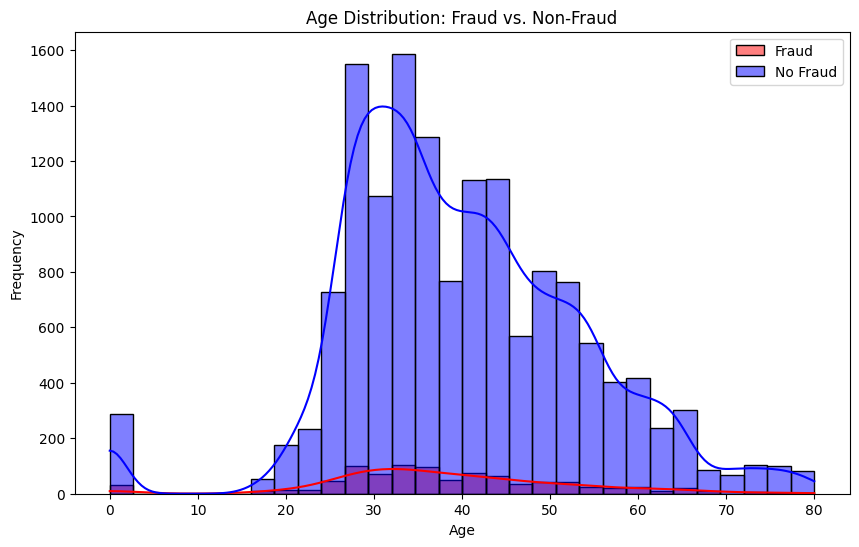

In [253]:
plt.figure(figsize=(10, 6))
sns.histplot(fraud[fraud["FraudFound_P"] == 1]["Age"], bins=30, kde=True, color="red", label="Fraud")
sns.histplot(fraud[fraud["FraudFound_P"] == 0]["Age"], bins=30, kde=True, color="blue", label="No Fraud", alpha=0.5)
plt.title("Age Distribution: Fraud vs. Non-Fraud")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.legend()
plt.show()


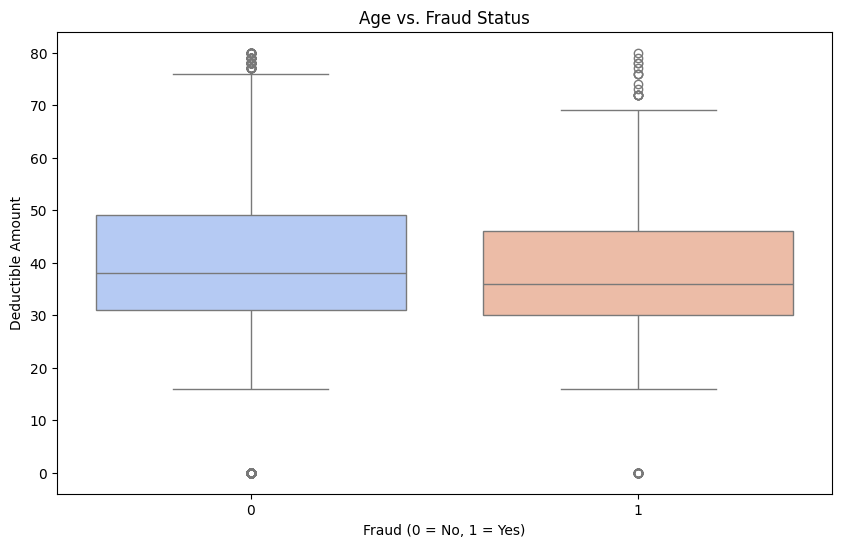

In [254]:
plt.figure(figsize=(10, 6))
sns.boxplot(x="FraudFound_P", y="Age", data=fraud, palette="coolwarm")
plt.title("Age vs. Fraud Status")
plt.xlabel("Fraud (0 = No, 1 = Yes)")
plt.ylabel("Deductible Amount")
plt.show()


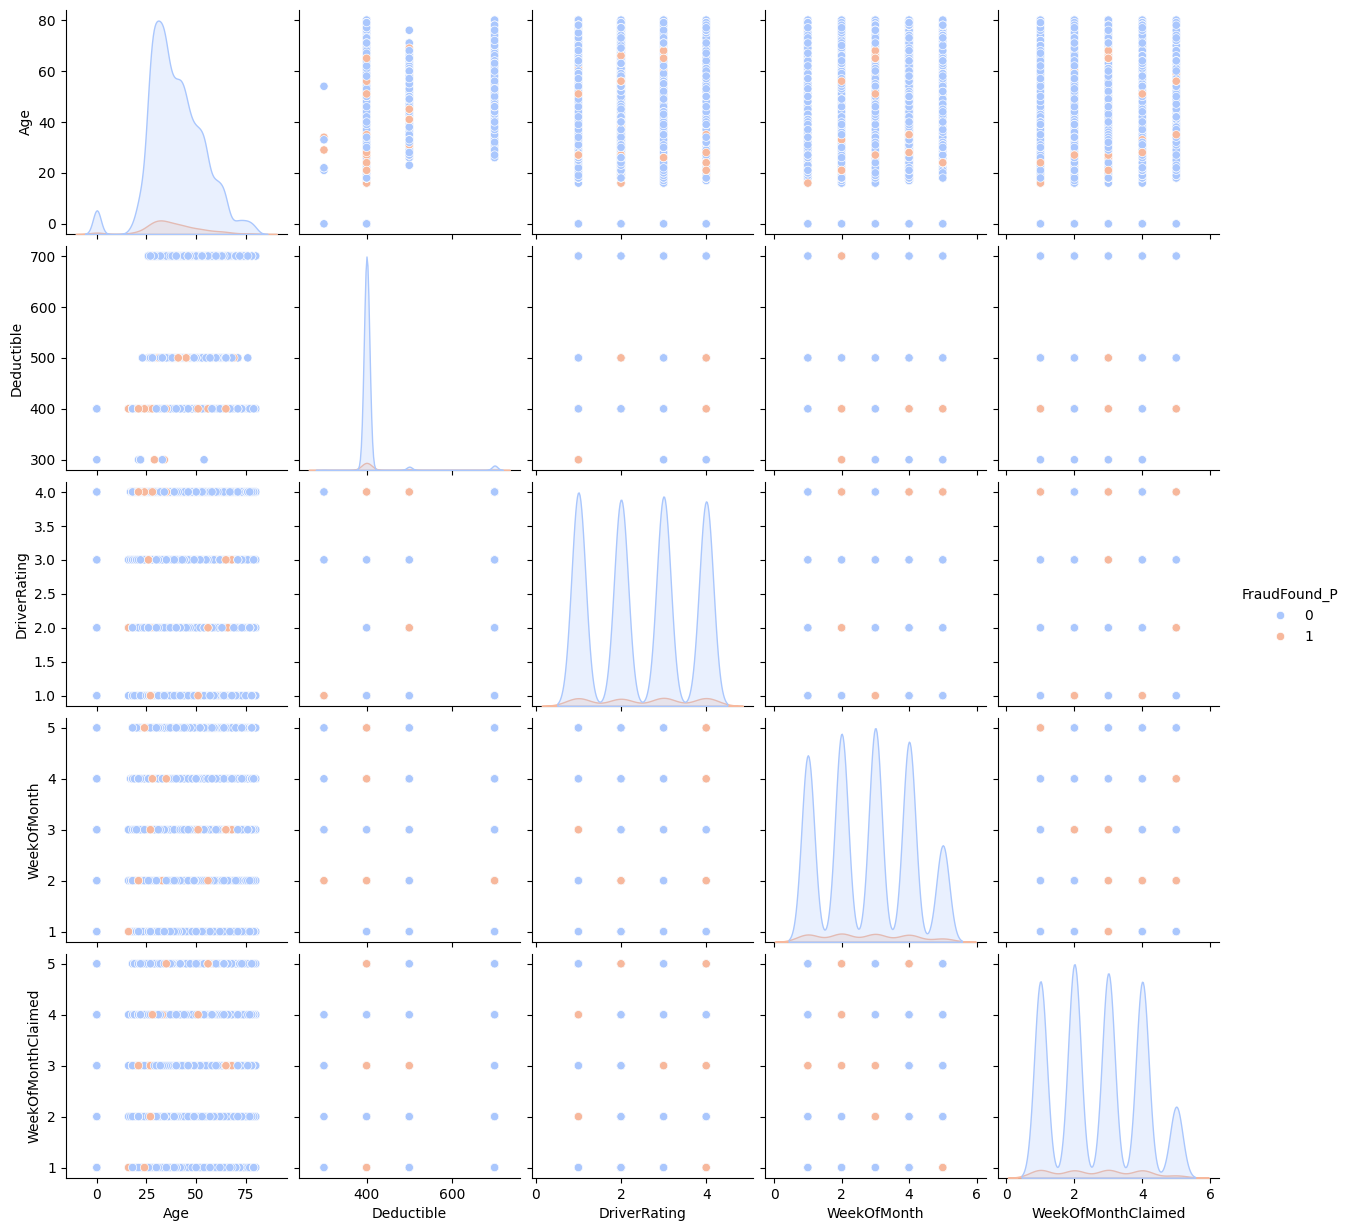

In [255]:
import seaborn as sns

# Selecting important numerical features
selected_features = ["Age", "Deductible", "DriverRating", "WeekOfMonth", "WeekOfMonthClaimed", "FraudFound_P"]

# Pairplot visualization
sns.pairplot(fraud[selected_features], hue="FraudFound_P", diag_kind="kde", palette="coolwarm")
plt.show()


Address change in fraud cases


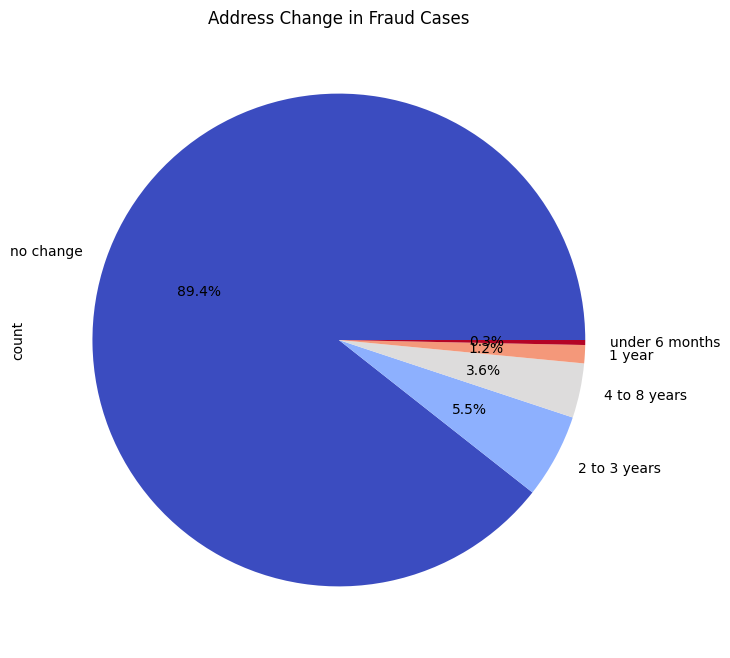

In [256]:
fraud[fraud["FraudFound_P"] == 1]["AddressChange_Claim"].value_counts().plot.pie(
    autopct="%1.1f%%", figsize=(8, 8), cmap="coolwarm")
plt.title("Address Change in Fraud Cases")
plt.show()


Fraud Rate by Month and Day of the Week

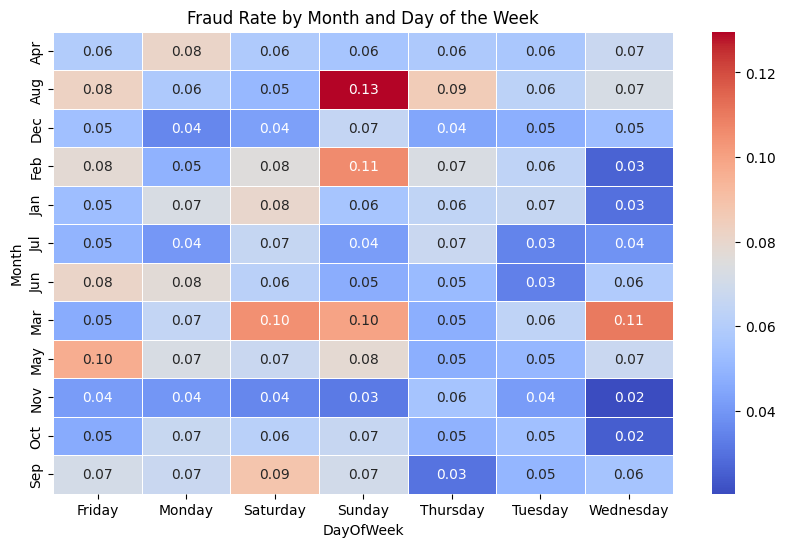

In [257]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Convert 'FraudFound_P' to numeric for calculations
fraud["FraudFound_P"] = fraud["FraudFound_P"].astype(int)

# Create a pivot table for fraud rates
fraud_heatmap = fraud.pivot_table(index="Month", columns="DayOfWeek", values="FraudFound_P", aggfunc="mean")

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(fraud_heatmap, cmap="coolwarm", annot=True, fmt=".2f", linewidths=0.5)
plt.title("Fraud Rate by Month and Day of the Week")
plt.show()

Fraud Rate by Age of Vehicle

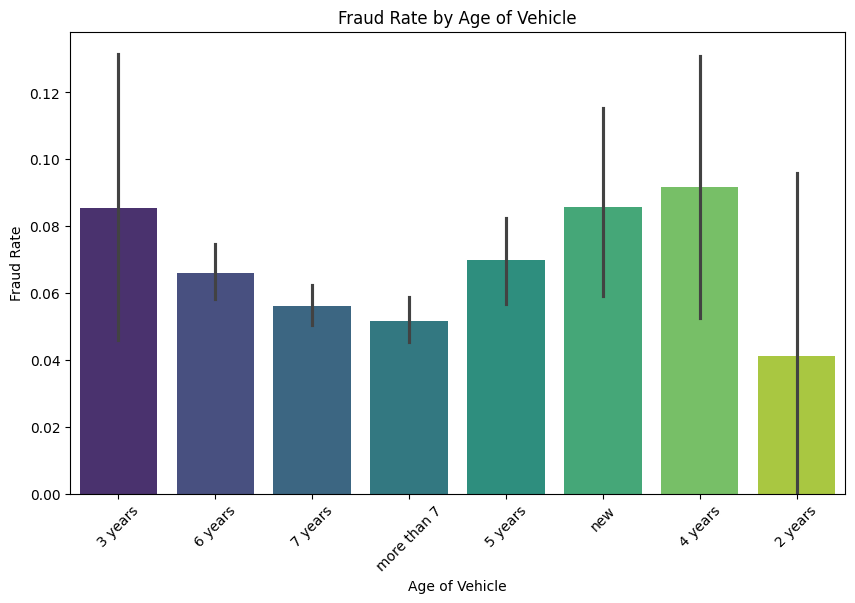

In [258]:
plt.figure(figsize=(10, 6))
sns.barplot(x="AgeOfVehicle", y="FraudFound_P", data=fraud, estimator=lambda x: sum(x)/len(x), palette="viridis")
plt.title("Fraud Rate by Age of Vehicle")
plt.xlabel("Age of Vehicle")
plt.ylabel("Fraud Rate")
plt.xticks(rotation=45)
plt.show()



Police Report Filed vs. Fraud

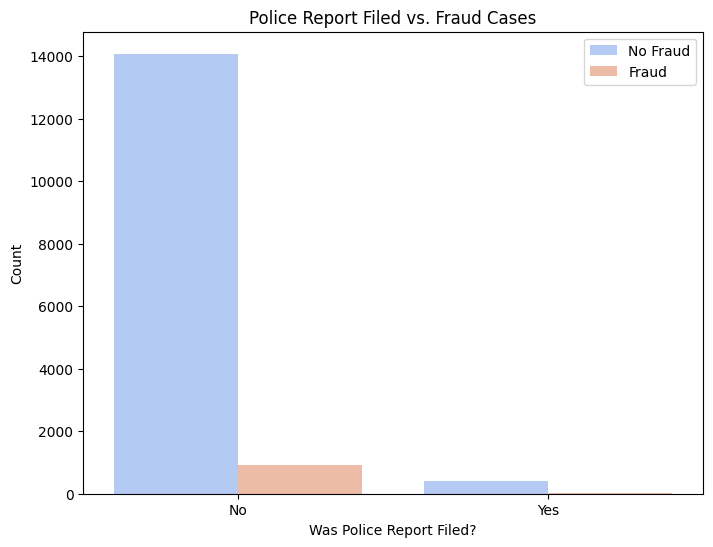

In [259]:
plt.figure(figsize=(8, 6))
sns.countplot(x="PoliceReportFiled", hue="FraudFound_P", data=fraud, palette="coolwarm")
plt.title("Police Report Filed vs. Fraud Cases")
plt.xlabel("Was Police Report Filed?")
plt.ylabel("Count")
plt.legend(["No Fraud", "Fraud"])
plt.show()


Distribution of Past Number of Claims in Fraud Cases

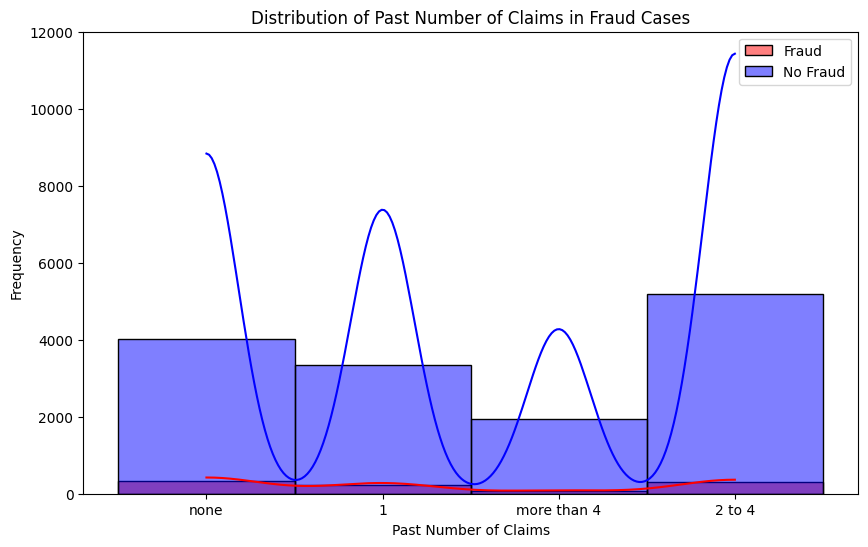

In [260]:
plt.figure(figsize=(10, 6))
sns.histplot(fraud[fraud["FraudFound_P"] == 1]["PastNumberOfClaims"], bins=10, kde=True, color="red", label="Fraud")
sns.histplot(fraud[fraud["FraudFound_P"] == 0]["PastNumberOfClaims"], bins=10, kde=True, color="blue", label="No Fraud", alpha=0.5)
plt.title("Distribution of Past Number of Claims in Fraud Cases")
plt.xlabel("Past Number of Claims")
plt.ylabel("Frequency")
plt.legend()
plt.show()


Fraud Trends Over Time: Animated Heatmap

In [261]:
import plotly.express as px

fraud_time = fraud.groupby(["Month", "DayOfWeek"])["FraudFound_P"].mean().reset_index()

fig = px.density_heatmap(fraud_time,
                         x="DayOfWeek",
                         y="Month",
                         z="FraudFound_P",
                         animation_frame="Month",
                         color_continuous_scale="reds")

fig.update_layout(title="Fraud Rate Fluctuation Over Time")
fig.show()



Fraud Clustering: 3D Scatter Plot

In [262]:
import plotly.express as px

fig = px.scatter_3d(fraud,
                     x="Age",
                     y="Deductible",
                     z="DriverRating",
                     color="FraudFound_P",
                     opacity=0.8)

fig.update_layout(title="3D View of Fraud Cases Based on Age, Deductible & Driver Rating")
fig.show()


Separating numerical and categorical variables

In [263]:
# Automatically separate numerical and categorical columns
num_cols = fraud.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = fraud.select_dtypes(include=['object']).columns.tolist()

print("Numerical Columns:", num_cols)
print("Categorical Columns:", cat_cols)


Numerical Columns: ['WeekOfMonth', 'WeekOfMonthClaimed', 'Age', 'FraudFound_P', 'PolicyNumber', 'RepNumber', 'Deductible', 'DriverRating', 'Year']
Categorical Columns: ['Month', 'DayOfWeek', 'Make', 'AccidentArea', 'DayOfWeekClaimed', 'MonthClaimed', 'Sex', 'MaritalStatus', 'Fault', 'PolicyType', 'VehicleCategory', 'VehiclePrice', 'Days_Policy_Accident', 'Days_Policy_Claim', 'PastNumberOfClaims', 'AgeOfVehicle', 'AgeOfPolicyHolder', 'PoliceReportFiled', 'WitnessPresent', 'AgentType', 'NumberOfSuppliments', 'AddressChange_Claim', 'NumberOfCars', 'BasePolicy']


Examining first few rows of the numerical data

In [264]:
# Display first few rows of only numerical columns
fraud[num_cols].head()


,WeekOfMonth,WeekOfMonthClaimed,Age,FraudFound_P,PolicyNumber,RepNumber,Deductible,DriverRating,Year
0,5,1,21,0,1,12,300,1,1994
1,3,4,34,0,2,15,400,4,1994
2,5,2,47,0,3,7,400,3,1994
3,2,1,65,0,4,4,400,2,1994
4,5,2,27,0,5,3,400,1,1994


Examining first few rows of categorical data

In [265]:
# Display first few rows of only categorical columns
fraud[cat_cols].head()


,Month,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,Sex,MaritalStatus,Fault,PolicyType,...,PastNumberOfClaims,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,BasePolicy
0,Dec,Wednesday,Honda,Urban,Tuesday,Jan,Female,Single,Policy Holder,Sport - Liability,...,none,3 years,26 to 30,No,No,External,none,1 year,3 to 4,Liability
1,Jan,Wednesday,Honda,Urban,Monday,Jan,Male,Single,Policy Holder,Sport - Collision,...,none,6 years,31 to 35,Yes,No,External,none,no change,1 vehicle,Collision
2,Oct,Friday,Honda,Urban,Thursday,Nov,Male,Married,Policy Holder,Sport - Collision,...,1,7 years,41 to 50,No,No,External,none,no change,1 vehicle,Collision
3,Jun,Saturday,Toyota,Rural,Friday,Jul,Male,Married,Third Party,Sedan - Liability,...,1,more than 7,51 to 65,Yes,No,External,more than 5,no change,1 vehicle,Liability
4,Jan,Monday,Honda,Urban,Tuesday,Feb,Female,Single,Third Party,Sport - Collision,...,none,5 years,31 to 35,No,No,External,none,no change,1 vehicle,Collision


Numerical data summary

In [266]:
# Numerical Data Summary
print("Numerical Data Summary:")
print(fraud[num_cols].describe())

Numerical Data Summary:
        WeekOfMonth  WeekOfMonthClaimed           Age  FraudFound_P  \
count  15420.000000        15420.000000  15420.000000  15420.000000   
mean       2.788586            2.693969     39.855707      0.059857   
std        1.287585            1.259115     13.492377      0.237230   
min        1.000000            1.000000      0.000000      0.000000   
25%        2.000000            2.000000     31.000000      0.000000   
50%        3.000000            3.000000     38.000000      0.000000   
75%        4.000000            4.000000     48.000000      0.000000   
max        5.000000            5.000000     80.000000      1.000000   

       PolicyNumber     RepNumber    Deductible  DriverRating          Year  
count  15420.000000  15420.000000  15420.000000  15420.000000  15420.000000  
mean    7710.500000      8.483268    407.704280      2.487808   1994.866472  
std     4451.514911      4.599948     43.950998      1.119453      0.803313  
min        1.000000     

Categorical data summary

In [267]:
# Categorical Data Summary
print("\nCategorical Data Summary:")
print(fraud[cat_cols].describe())


Categorical Data Summary:
        Month DayOfWeek     Make AccidentArea DayOfWeekClaimed MonthClaimed  \
count   15420     15420    15420        15420            15420        15420   
unique     12         7       19            2                8           13   
top       Jan    Monday  Pontiac        Urban           Monday          Jan   
freq     1411      2616     3837        13822             3757         1446   

          Sex MaritalStatus          Fault         PolicyType  ...  \
count   15420         15420          15420              15420  ...   
unique      2             4              2                  9  ...   
top      Male       Married  Policy Holder  Sedan - Collision  ...   
freq    13000         10625          11230               5584  ...   

       PastNumberOfClaims AgeOfVehicle AgeOfPolicyHolder PoliceReportFiled  \
count               15420        15420             15420             15420   
unique                  4            8                 9              

Average value of numerical variables by class of target variable

In [268]:
# Bivariate Analysis: Average value of numerical variables by class of the target variable
# Group the dataset by the target variable ('FraudFound_P')
# and calculate the mean of all numerical features
fraud.groupby(['FraudFound_P'])[num_cols].mean()



,WeekOfMonth,WeekOfMonthClaimed,Age,FraudFound_P,PolicyNumber,RepNumber,Deductible,DriverRating,Year
FraudFound_P,,,,,,,,,
0,2.792440,2.695799,39.956957,0.0,7733.351038,8.492033,407.511899,2.485756,1994.871491
1,2.728061,2.665222,38.265439,1.0,7351.592633,8.345612,410.725894,2.520043,1994.787649


Looking at relative frequencies of categorical variables by class of target

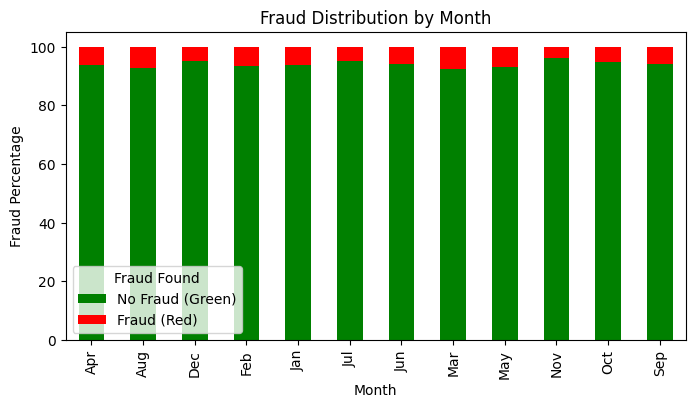

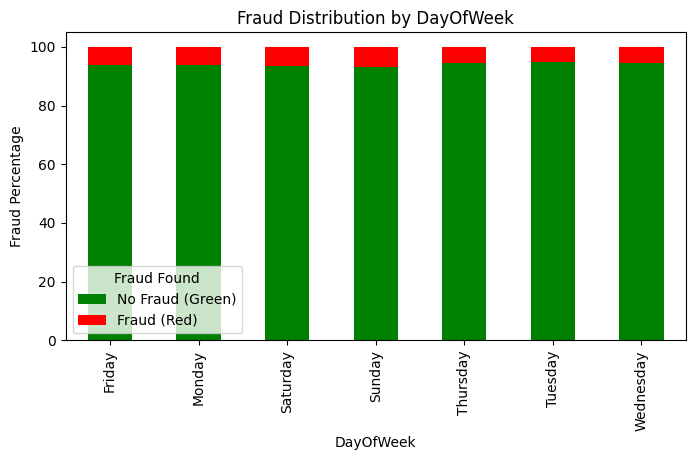

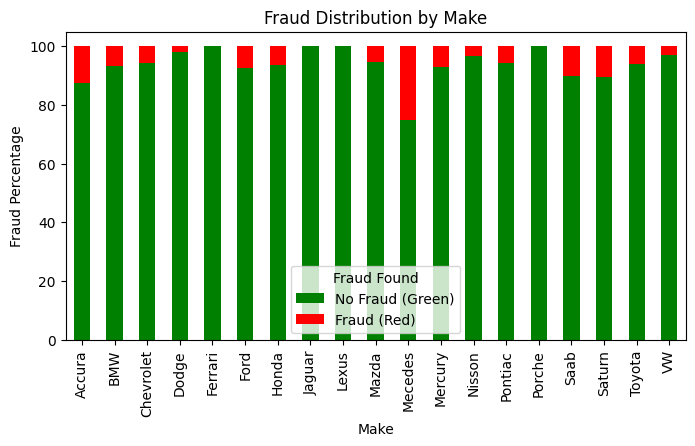

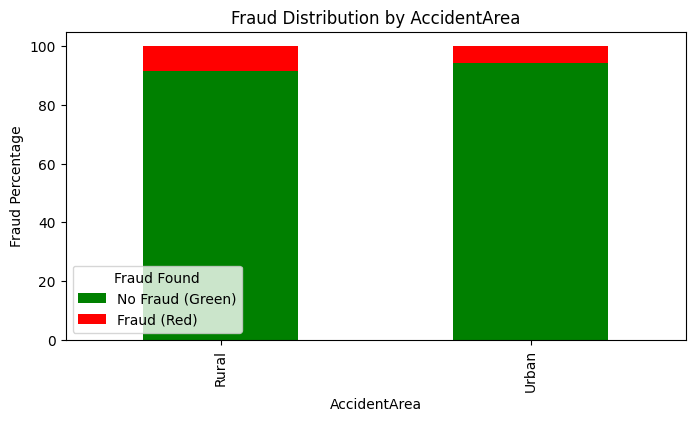

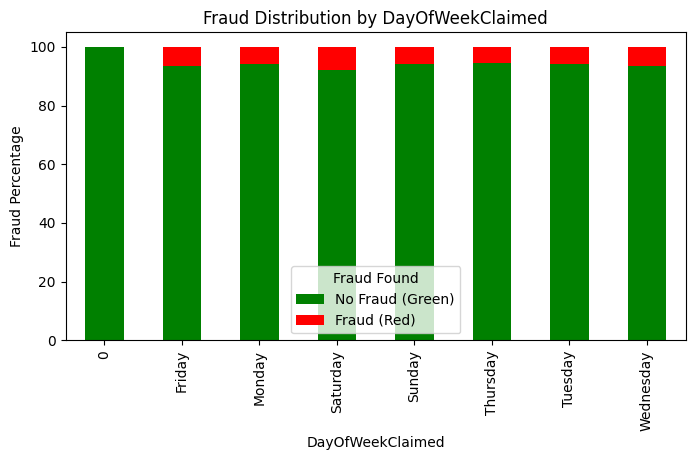

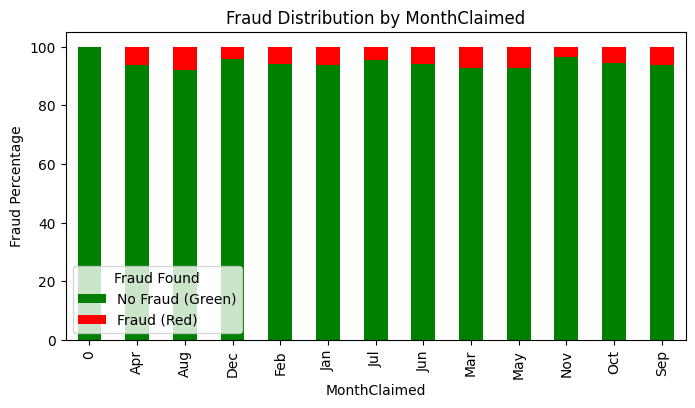

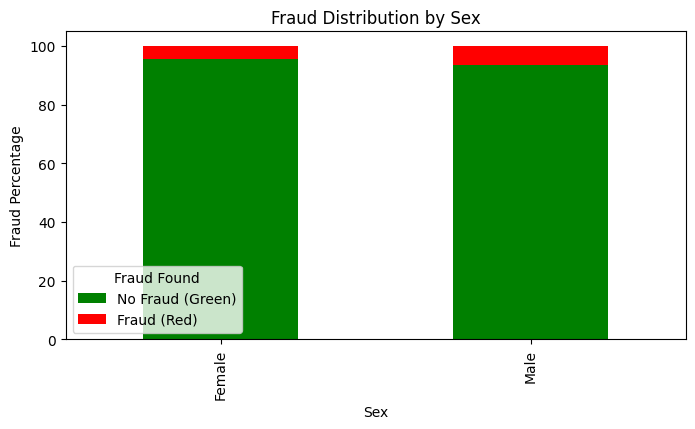

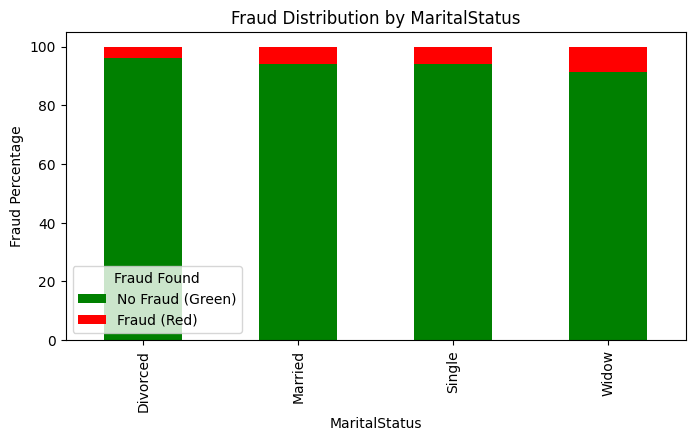

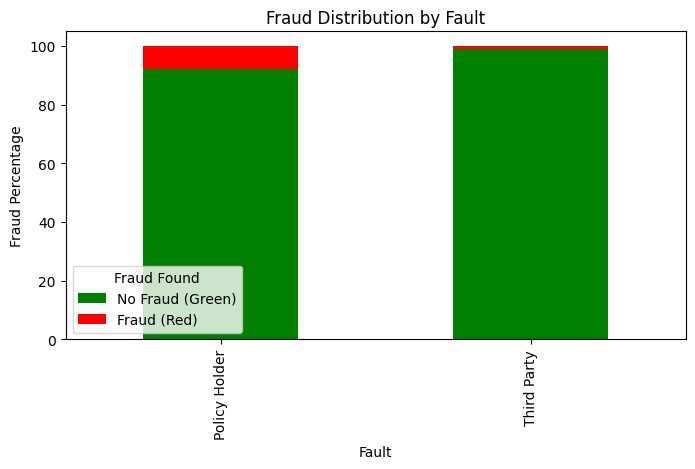

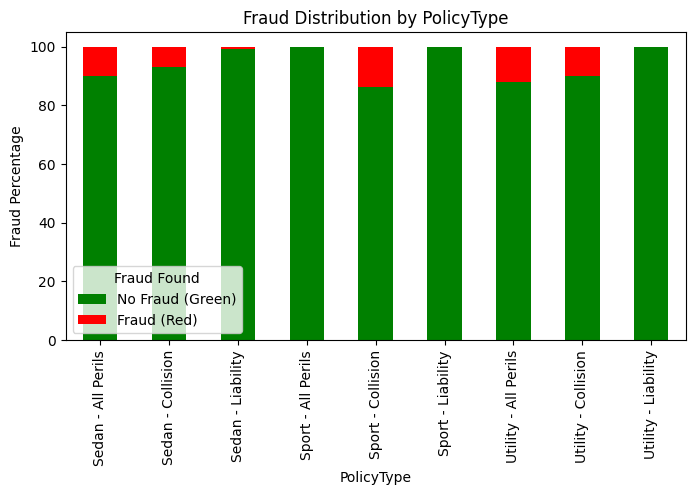

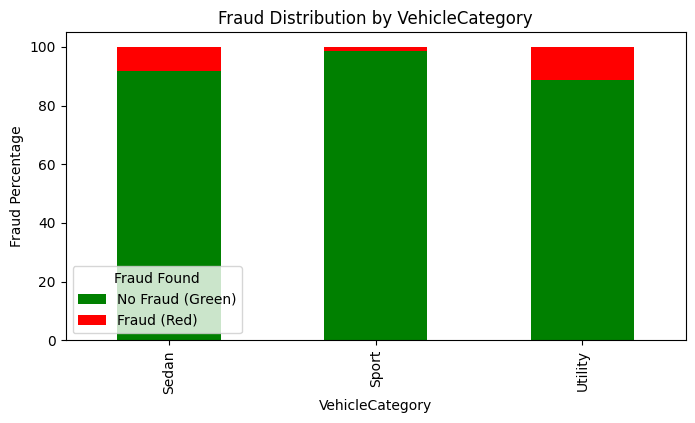

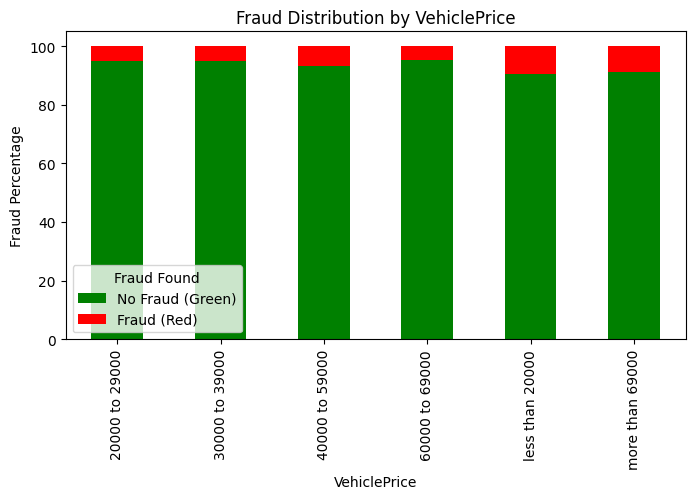

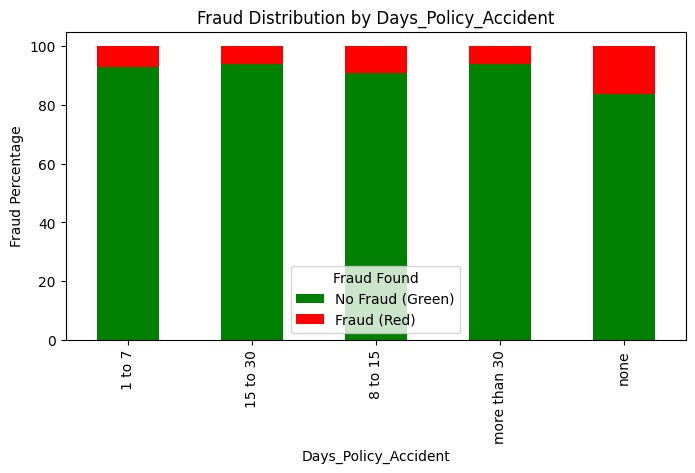

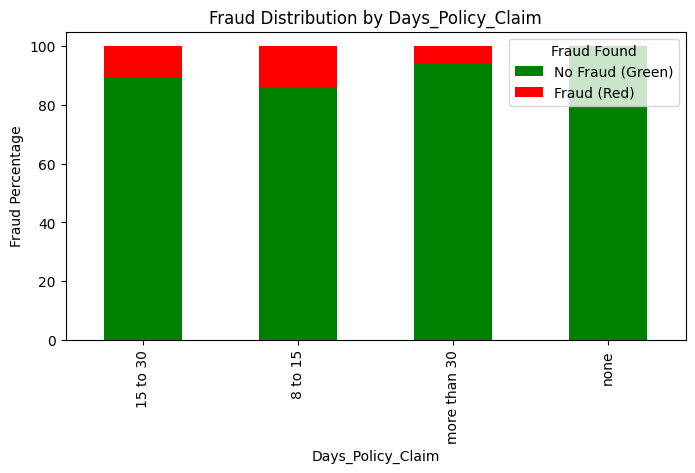

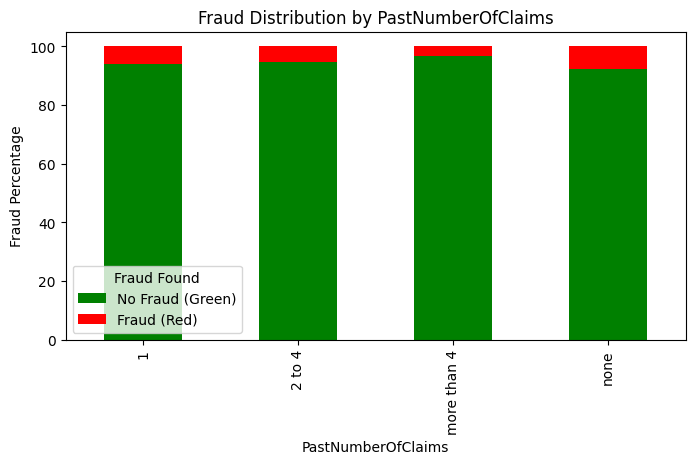

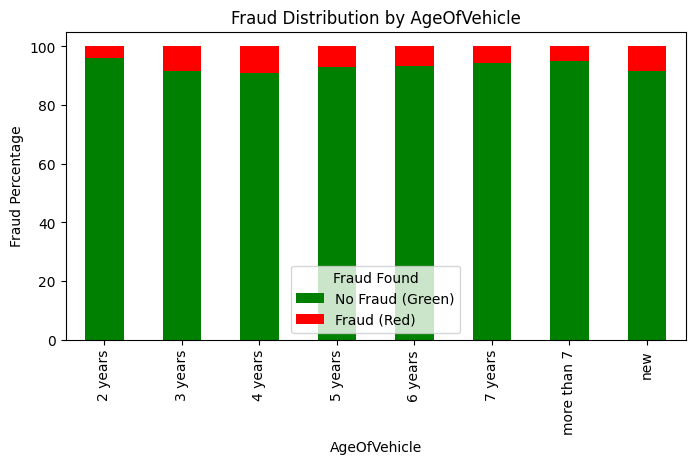

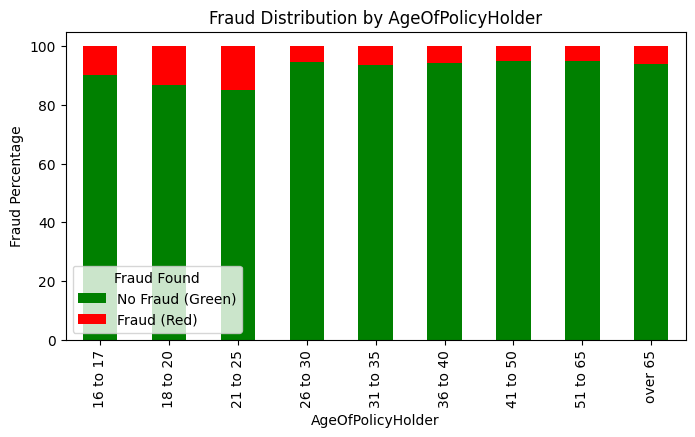

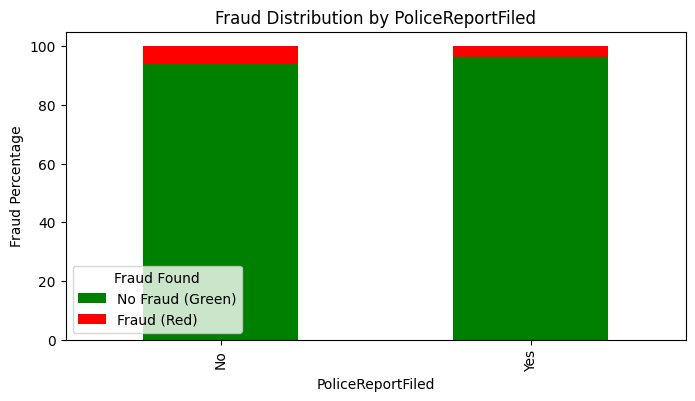

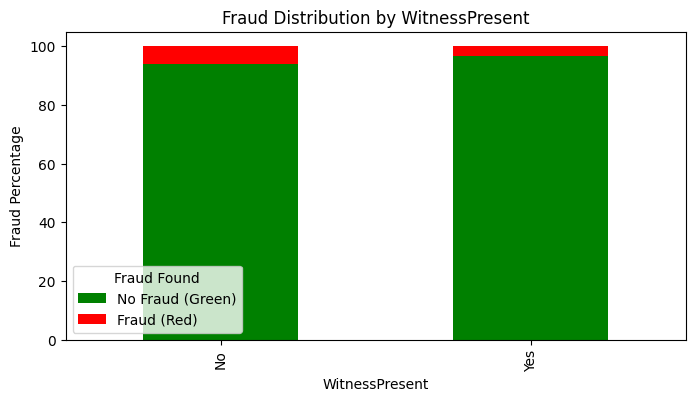

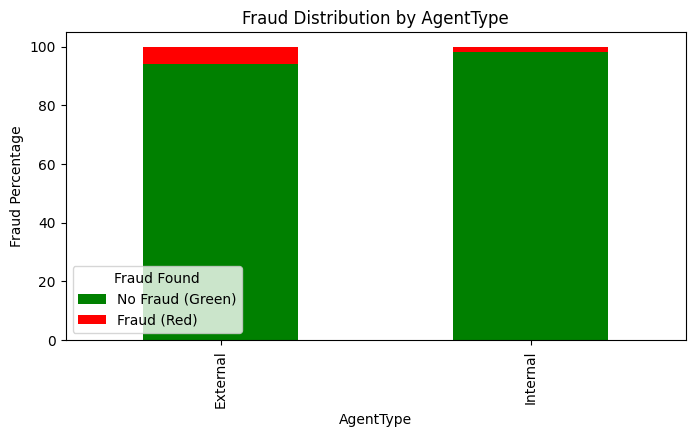

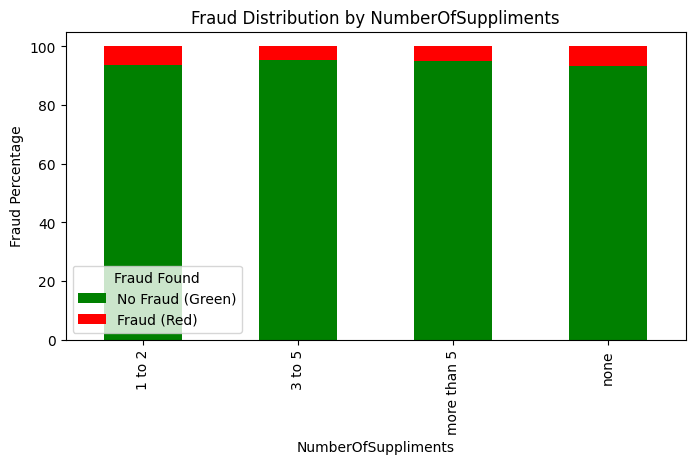

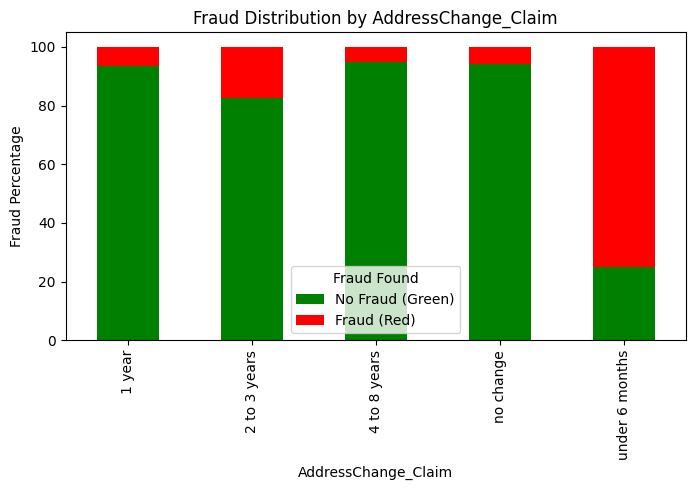

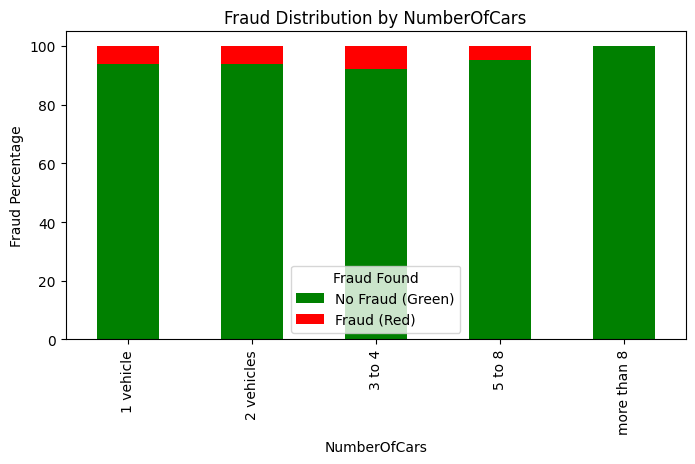

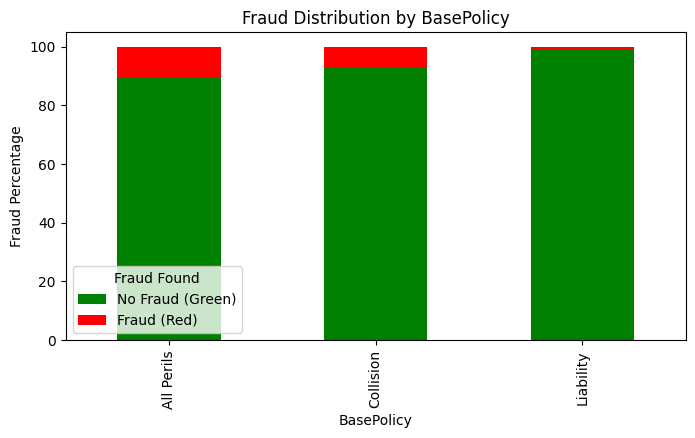

In [269]:
import pandas as pd
import matplotlib.pyplot as plt

# Define custom colors: Green for non-fraud, Red for fraud
custom_colors = ['green', 'red']  # Non-fraud = green, Fraud = red

for i in cat_cols:  # Loop through categorical columns
    if i != 'FraudFound_P':  # Ensure we don't process the target variable itself
        pd.crosstab(fraud[i], fraud['FraudFound_P'], normalize='index') \
        .mul(100) \
        .plot(kind='bar', figsize=(8,4), stacked=True, color=custom_colors)  # Apply custom colors

        plt.ylabel('Fraud Percentage')
        plt.title(f"Fraud Distribution by {i}")
        plt.legend(title="Fraud Found", labels=["No Fraud (Green)", "Fraud (Red)"])  # Updated legend
        plt.show()




Creating dummy variables for the categorical variables

In [270]:
for col in cat_cols: # checking for unique values in each categorical column
    print(f"\nUnique values in {col}: {fraud[col].unique()}")


Unique values in Month: ['Dec' 'Jan' 'Oct' 'Jun' 'Feb' 'Nov' 'Apr' 'Mar' 'Aug' 'Jul' 'May' 'Sep']

Unique values in DayOfWeek: ['Wednesday' 'Friday' 'Saturday' 'Monday' 'Tuesday' 'Sunday' 'Thursday']

Unique values in Make: ['Honda' 'Toyota' 'Ford' 'Mazda' 'Chevrolet' 'Pontiac' 'Accura' 'Dodge'
 'Mercury' 'Jaguar' 'Nisson' 'VW' 'Saab' 'Saturn' 'Porche' 'BMW' 'Mecedes'
 'Ferrari' 'Lexus']

Unique values in AccidentArea: ['Urban' 'Rural']

Unique values in DayOfWeekClaimed: ['Tuesday' 'Monday' 'Thursday' 'Friday' 'Wednesday' 'Saturday' 'Sunday'
 '0']

Unique values in MonthClaimed: ['Jan' 'Nov' 'Jul' 'Feb' 'Mar' 'Dec' 'Apr' 'Aug' 'May' 'Jun' 'Sep' 'Oct'
 '0']

Unique values in Sex: ['Female' 'Male']

Unique values in MaritalStatus: ['Single' 'Married' 'Widow' 'Divorced']

Unique values in Fault: ['Policy Holder' 'Third Party']

Unique values in PolicyType: ['Sport - Liability' 'Sport - Collision' 'Sedan - Liability'
 'Utility - All Perils' 'Sedan - All Perils' 'Sedan - Collision'
 'Util

In [271]:
fraud.head()

,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,...,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy
0,Dec,5,Wednesday,Honda,Urban,Tuesday,Jan,1,Female,Single,...,3 years,26 to 30,No,No,External,none,1 year,3 to 4,1994,Liability
1,Jan,3,Wednesday,Honda,Urban,Monday,Jan,4,Male,Single,...,6 years,31 to 35,Yes,No,External,none,no change,1 vehicle,1994,Collision
2,Oct,5,Friday,Honda,Urban,Thursday,Nov,2,Male,Married,...,7 years,41 to 50,No,No,External,none,no change,1 vehicle,1994,Collision
3,Jun,2,Saturday,Toyota,Rural,Friday,Jul,1,Male,Married,...,more than 7,51 to 65,Yes,No,External,more than 5,no change,1 vehicle,1994,Liability
4,Jan,5,Monday,Honda,Urban,Tuesday,Feb,2,Female,Single,...,5 years,31 to 35,No,No,External,none,no change,1 vehicle,1994,Collision


In [272]:
# Label Encoding for Binary Categorical Variables
from sklearn.preprocessing import LabelEncoder

binary_cols = [col for col in cat_cols if fraud[col].nunique() == 2]  # Find binary categorical columns
multi_class_cols = [col for col in cat_cols if fraud[col].nunique() > 2]  # Find multi-class categorical columns

# Apply Label Encoding for binary categorical columns
le = LabelEncoder()
for col in binary_cols:
    fraud[col] = le.fit_transform(fraud[col])

# Apply One-Hot Encoding for multi-class categorical columns
fraud = pd.get_dummies(fraud, columns=multi_class_cols, drop_first=True)


In [273]:
# Identify categorical columns
cat_cols = fraud.select_dtypes(include=['object']).columns.tolist()

# Find categorical columns with more than 2 unique values
multi_class_cols = [col for col in cat_cols if fraud[col].nunique() > 2]

print("Categorical columns requiring One-Hot Encoding:", multi_class_cols)


Categorical columns requiring One-Hot Encoding: []


Converting True/False to 1 and 0

In [274]:
# Convert boolean (True/False) columns to integer (1/0)
fraud = fraud.astype(int)

# Verify the changes
print(fraud.dtypes)  # Check if all columns are now numerical
print(fraud.head())  # Preview first few rows


WeekOfMonth                 int64
AccidentArea                int64
WeekOfMonthClaimed          int64
Sex                         int64
Age                         int64
                            ...  
NumberOfCars_3 to 4         int64
NumberOfCars_5 to 8         int64
NumberOfCars_more than 8    int64
BasePolicy_Collision        int64
BasePolicy_Liability        int64
Length: 125, dtype: object
   WeekOfMonth  AccidentArea  WeekOfMonthClaimed  Sex  Age  Fault  \
0            5             1                   1    0   21      0   
1            3             1                   4    1   34      0   
2            5             1                   2    1   47      0   
3            2             0                   1    1   65      1   
4            5             1                   2    0   27      1   

   FraudFound_P  PolicyNumber  RepNumber  Deductible  ...  \
0             0             1         12         300  ...   
1             0             2         15         400  ...   
2

First few rows of transformed data set

In [275]:
fraud.head()

,WeekOfMonth,AccidentArea,WeekOfMonthClaimed,Sex,Age,Fault,FraudFound_P,PolicyNumber,RepNumber,Deductible,...,AddressChange_Claim_2 to 3 years,AddressChange_Claim_4 to 8 years,AddressChange_Claim_no change,AddressChange_Claim_under 6 months,NumberOfCars_2 vehicles,NumberOfCars_3 to 4,NumberOfCars_5 to 8,NumberOfCars_more than 8,BasePolicy_Collision,BasePolicy_Liability
0,5,1,1,0,21,0,0,1,12,300,...,0,0,0,0,0,1,0,0,0,1
1,3,1,4,1,34,0,0,2,15,400,...,0,0,1,0,0,0,0,0,1,0
2,5,1,2,1,47,0,0,3,7,400,...,0,0,1,0,0,0,0,0,1,0
3,2,0,1,1,65,1,0,4,4,400,...,0,0,1,0,0,0,0,0,0,1
4,5,1,2,0,27,1,0,5,3,400,...,0,0,1,0,0,0,0,0,1,0


In [276]:
fraud.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15420 entries, 0 to 15419
Columns: 125 entries, WeekOfMonth to BasePolicy_Liability
dtypes: int64(125)
memory usage: 14.7 MB


Separating the feature variables from the target variable

In [277]:
# Separate target variable ('FraudFound_P') from feature variables
y = fraud['FraudFound_P']  # Target variable
X = fraud.drop(columns=['FraudFound_P'])  # Features (all other columns)

# Verify the shapes
print("Features Shape:", X.shape)
print("Target Shape:", y.shape)


Features Shape: (15420, 124)
Target Shape: (15420,)


Correlation heatmap

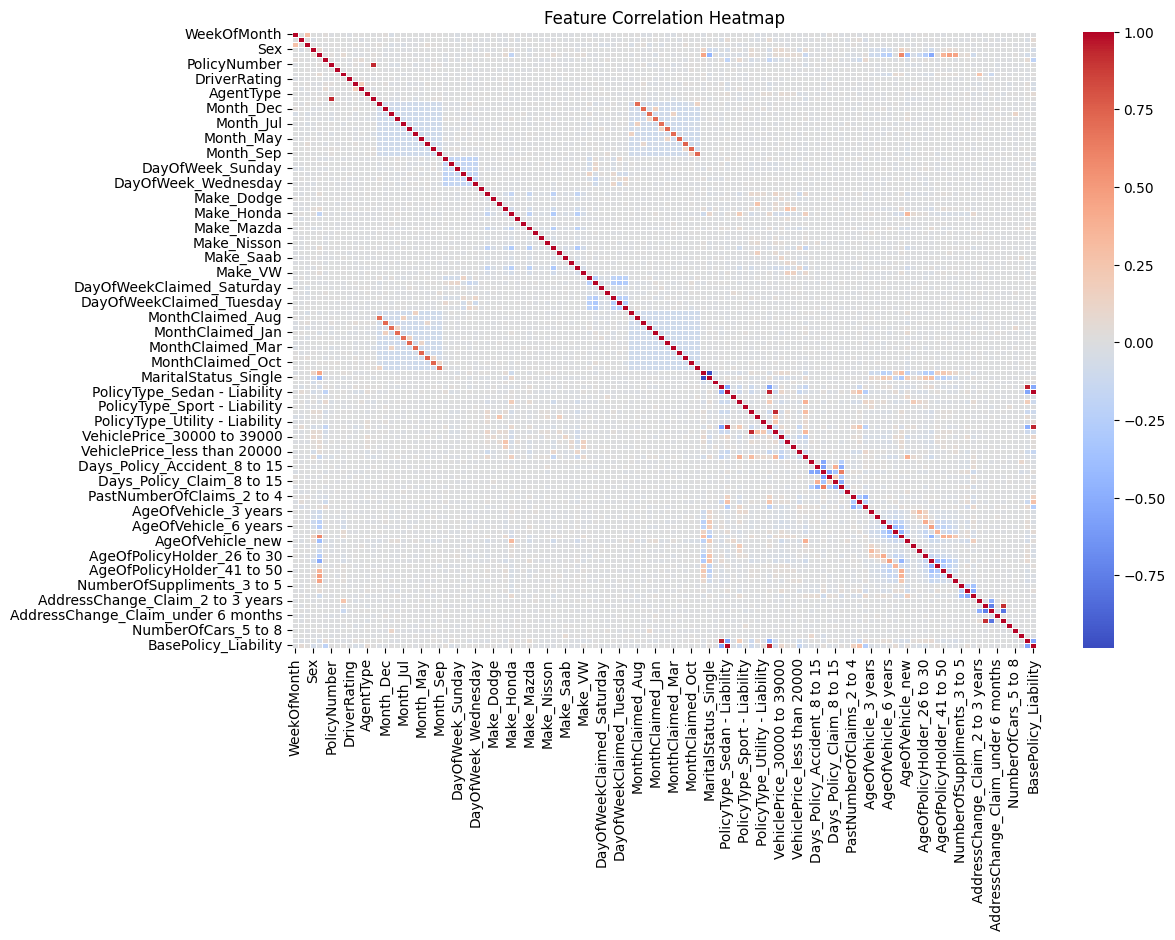

Highly Correlated Features (Threshold > 0.9):
['Year', 'MaritalStatus_Single', 'VehicleCategory_Sport', 'VehicleCategory_Utility', 'NumberOfCars_2 vehicles', 'BasePolicy_Collision', 'BasePolicy_Liability']


In [278]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrix
corr_matrix = X.corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, cmap="coolwarm", annot=False, linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

# Compute correlation matrix (absolute values)
corr_matrix = X.corr().abs()

# Select the upper triangle of the correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation higher than 0.9
high_corr_features = [column for column in upper.columns if any(upper[column] > 0.9)]

# Print highly correlated features
print("Highly Correlated Features (Threshold > 0.9):")
print(high_corr_features)


Removing highly correlated features

In [279]:
# Drop highly correlated features (Threshold > 0.9)
X.drop(columns=['Year', 'MaritalStatus_Single', 'VehicleCategory_Sport', 'VehicleCategory_Utility',
                'NumberOfCars_2 vehicles', 'BasePolicy_Collision', 'BasePolicy_Liability'], inplace=True)

# Verify shape after dropping correlated features
print("Updated Feature Shape after removing highly correlated features:", X.shape)


Updated Feature Shape after removing highly correlated features: (15420, 117)


Feature Engineering

In [280]:
#  Creating a "Claim Complexity" Feature
# This captures how many claims an agent handles per policy.
X["ClaimComplexity"] = X["PolicyNumber"] / (X["RepNumber"] + 1)  # Avoid division by zero

#  Verify the new feature
print("Updated Feature Shape after feature engineering:", X.shape)
print(X[["PolicyNumber", "RepNumber", "ClaimComplexity"]].head())  # Preview the new feature


Updated Feature Shape after feature engineering: (15420, 118)
   PolicyNumber  RepNumber  ClaimComplexity
0             1         12         0.076923
1             2         15         0.125000
2             3          7         0.375000
3             4          4         0.800000
4             5          3         1.250000


Outlier detection and removal

In [281]:
import numpy as np

# Re-load dataset correctly and ensure dropped features stay removed
X = fraud.drop(columns=['FraudFound_P'])  # Restore original X

#  Drop the highly correlated features again (ensuring consistency)
correlated_features = ['Year', 'MaritalStatus_Single', 'VehicleCategory_Sport',
                       'VehicleCategory_Utility', 'NumberOfCars_2 vehicles',
                       'BasePolicy_Collision', 'BasePolicy_Liability']
X.drop(columns=correlated_features, inplace=True, errors='ignore')

#  Compute IQR (Interquartile Range) for Outlier Detection
Q1 = X.quantile(0.25)
Q3 = X.quantile(0.75)
IQR = Q3 - Q1

#  Define Outlier Threshold (Capping Instead of Removal)
outlier_threshold = 3.0
lower_bound = Q1 - outlier_threshold * IQR
upper_bound = Q3 + outlier_threshold * IQR

#  Instead of removing, CAP outliers to upper/lower limits
X = X.clip(lower=lower_bound, upper=upper_bound, axis=1)

#  Verify shape after outlier handling
print("Updated Feature Shape after outlier handling:", X.shape)



Updated Feature Shape after outlier handling: (15420, 117)


Standard scaler to transform the values in the collection of feature values

In [282]:
from sklearn.preprocessing import StandardScaler

# Initialize StandardScaler
sc = StandardScaler()

# Fit and transform the feature variables (X)
X_scaled = sc.fit_transform(X)

# Convert scaled data back into a DataFrame with original column names
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# Verify the transformation
print("Scaled Features Shape:", X_scaled.shape)
print(X_scaled.head())  # Check first few rows after scaling


Scaled Features Shape: (15420, 117)
   WeekOfMonth  AccidentArea  WeekOfMonthClaimed  Sex       Age     Fault  \
0     1.717545           0.0           -1.345408  0.0 -1.397554 -0.610825   
1     0.164199           0.0            1.037295  0.0 -0.434015 -0.610825   
2     1.717545           0.0           -0.551174  0.0  0.529523 -0.610825   
3    -0.612473           0.0           -1.345408  0.0  1.863653  1.637129   
4     1.717545           0.0           -0.551174  0.0 -0.952844  1.637129   

   PolicyNumber  RepNumber  Deductible  DriverRating  ...  \
0     -1.731938   0.764540         0.0     -1.329092  ...   
1     -1.731714   1.416743         0.0      1.350875  ...   
2     -1.731489  -0.322464         0.0      0.457553  ...   
3     -1.731265  -0.974666         0.0     -0.435770  ...   
4     -1.731040  -1.192067         0.0     -1.329092  ...   

   NumberOfSuppliments_3 to 5  NumberOfSuppliments_more than 5  \
0                         0.0                        -0.578548   
1 

Train-Test Split

In [283]:
from sklearn.model_selection import train_test_split

# Split into 80% train and 20% test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Verify the split
print("Training Features Shape:", X_train.shape)
print("Testing Features Shape:", X_test.shape)
print("Training Target Shape:", y_train.shape)
print("Testing Target Shape:", y_test.shape)


Training Features Shape: (12336, 117)
Testing Features Shape: (3084, 117)
Training Target Shape: (12336,)
Testing Target Shape: (3084,)
